Number of classes: 5


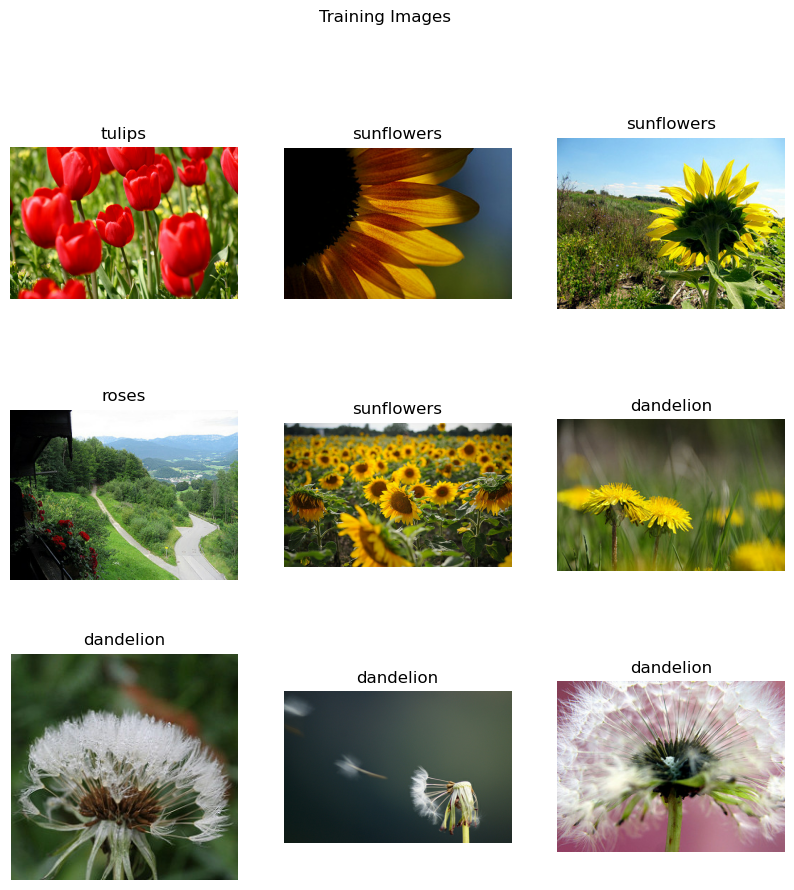

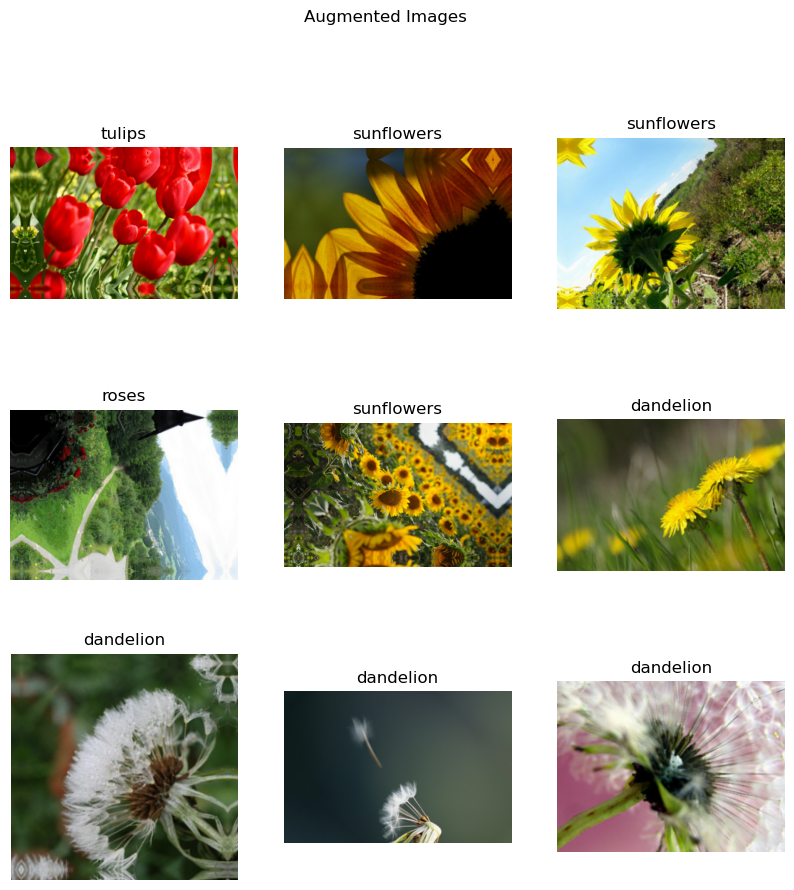

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.3172 - loss: 1.8018 - val_accuracy: 0.5749 - val_loss: 1.0735
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.5873 - loss: 1.0517 - val_accuracy: 0.6676 - val_loss: 0.9466
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.6402 - loss: 0.9135 - val_accuracy: 0.6540 - val_loss: 0.9156
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.7225 - loss: 0.7544 - val_accuracy: 0.6894 - val_loss: 0.8513
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.7831 - loss: 0.5837 - val_accuracy: 0.6730 - val_loss: 0.9320
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.8390 - loss: 0.4588 - val_accuracy: 0.6975 - val_loss: 0.9249
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.8898 - loss: 0.3367 - val_accuracy: 0.6839 - val_loss: 1.0605
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.9197 - loss: 0.2480 - val_accu

In [20]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

# Load the dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(f"Number of classes: {num_classes}")

get_label_name = metadata.features['label'].int2str

# Display sample images
def show_images(dataset, title):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(get_label_name(label.numpy()))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(train_ds, "Training Images")

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Apply augmentation and display
def show_augmented_images(dataset):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(get_label_name(label.numpy()))
        plt.axis("off")
    plt.suptitle("Augmented Images")
    plt.show()

show_augmented_images(train_ds)

# Prepare dataset for training
def preprocess_image(image, label):
    image = tf.image.resize(image, (180, 180)) / 255.0
    return image, label

train_ds = train_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Define CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping])

# Evaluate model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
